In [1]:
import pandas as pd
import numpy as np
import tweepy
import emoji
from torch import torch, nn
import seaborn as sns
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer

Get the trained tokenizer and add our own special tokens [USR], [LNK]

In [3]:

PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_special_tokens({"additional_special_tokens": ["[USR]", "[LNK]"]})


2

This function reduces chains of the same token down to just one instance of it.

In [4]:
def remove_repeat_tokens(tweet_text):
    words = tweet_text.split(' ')

    for i in range(len(words) - 2, -1, -1):
        if words[i] == "[USR]" and words[i+1] == "[USR]":
            words.pop(i+1)

        if words[i] == "[LNK]" and words[i+1] == "[LNK]":
            words.pop(i+1)

    return ' '.join(words)


Load processed text segments and remove those that, when encoded, have a token size less than 2.

In [5]:
emoji_list = ['joy',
            'heart',
            'sob',
            'heart_eyes',
            #'recycle',
            'hearts',
            'blush',
            'two_hearts',
            'kissing_heart',
            'pensive',
            ]

df_list = []
sizes = []
min_size = 999999

for emj in emoji_list:
    filename = "data/" + emj + "_no_media.csv"

    df = pd.read_csv(filename, sep='^([^,]+),')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    df.text = df.apply(lambda row: remove_repeat_tokens(row.text), axis=1)

    #remove super short tweets
    df = df.drop(df[ df.text.map(lambda x: len(tokenizer.encode(x))) < 2 ].index)

    df_list.append(df)

    size = len(df.index)
    print(size)
    sizes.append(size)

    if size < min_size:
        min_size = size

/home/tho121/CMPT413/project/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


111809
70368
118723
88681
73788
88274
63875
70085
113561


Build the training dataset by randomly sampling from the top emojis, using the smallest included dataset size as the minimum value. Alternatively, set the minimum size to overwrite it, such as for parameter exploration.

In [6]:
num_classes = 5     #max is 9
indices = sorted(range(len(sizes)), key=lambda i: sizes[i])[-num_classes:]
min_size = sizes[indices[-num_classes]]

#TEMP, set size for parameter exploration, else comment out
min_size = 3000

samples = []

for i, df in enumerate(df_list):
    if i in indices:
        df_samples = df.sample(n=min_size)
        print(df_samples.groupby(['emoji']).size())
        samples.append(df_samples)

df = pd.concat(samples)

print(df)

emoji
😂    3000
dtype: int64
emoji
😭    3000
dtype: int64
emoji
😍    3000
dtype: int64
emoji
😊    3000
dtype: int64
emoji
😔    3000
dtype: int64
       emoji                                               text
2020       😂                                      [USR] Aaaaaah
11951      😂  [USR] You gotta be trolling fella. I don't giv...
52625      😂  [USR] Worst thing is that we won’t be able to ...
40055      😂              [USR] That’s what I was thinking! Lol
107937     😂  [USR] A free market of “digital gold” controll...
...      ...                                                ...
87823      😔  [USR] Have a friend with residents who were wa...
27450      😔  [USR] jealous that you skipped the Max Medina ...
23310      😔            [USR] i think i just never works for me
7716       😔                                [USR] It's shameful
80391      😔  If I were given the chance I would go as this ...

[15000 rows x 2 columns]


In [7]:
df.reset_index(drop=True, inplace=True)
df

,emoji,text
0,😂,[USR] So he can stay alive
1,😂,"[USR] Yeah, poor Hayato"
2,😂,[USR]
3,😂,[USR] It’s more funny when you see other men h...
4,😂,[USR] Oh Acha
...,...,...
14995,😔,I Haven’t Had Sex Since Sex Had Me
14996,😔,[USR] LOL damn yeah u got me
14997,😔,[USR] Ummmm…no words.
14998,😔,[USR] I nearly placed that bet


5
emoji
😂    3000
😊    3000
😍    3000
😔    3000
😭    3000
dtype: int64


/home/tho121/CMPT413/project/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='emoji', ylabel='count'>

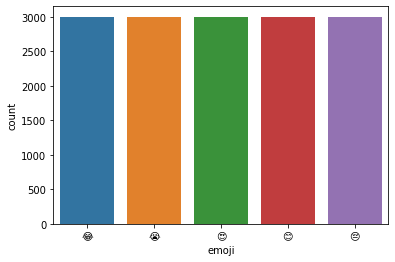

In [8]:
print(df.groupby(['emoji']).ngroups)
print(df.groupby(['emoji']).size())
sns.countplot(df.emoji)

Convert the emojis to intergers for the labels.

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.emoji = label_encoder.fit_transform(df.emoji)

Find the sample with the largest number of tokens, all other tokens will be padded to fit this size.

In [10]:
tweets = df.text.to_numpy()
max_token_len = 0
for tweet in tweets:
    tokenized_tweet = tokenizer.encode(tweet)
    size = len(tokenized_tweet)
    if size > max_token_len:
        max_token_len = size


In [11]:
max_token_len

135

Define the custom dataloader class that converts the samples to input for the DistilBert model.

In [8]:
#https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

from torch.utils.data import Dataset, DataLoader

class EmojiPredictionDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):

    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):

    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1)
df_val, df_test = train_test_split(df_test, test_size=0.5)

Create the dataloader for the train, validation, and test sets.

In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = EmojiPredictionDataset(
    tweets=df.text.to_numpy(),
    targets=df.emoji.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16
MAX_LEN = max_token_len + 1

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Define the class that uses the DistilBert model and attach a classification head. Be sure to resize the token embedding size since they were modified to include the [USR] and [LNK] tokens.

In [9]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, tokenizer):
    super(SentimentClassifier, self).__init__()

    bert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    bert_model.resize_token_embeddings(len(tokenizer))

    #freeze bert model
    #for param in bert_model.base_model.parameters():
    #    param.requires_grad = False

    self.bert = bert_model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    #_, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
    distilbert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = distilbert_output[0]                    
    pooled_output = hidden_state[:, 0]
    output = self.drop(pooled_output)
    return self.out(output)

Free up some memory cause I'm running on a laptop with 6 GB of VRAM.

In [17]:
torch.cuda.empty_cache()

In [18]:
model = SentimentClassifier(df.groupby(['emoji']).ngroups, tokenizer)
model = model.cuda()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
data = next(iter(train_data_loader))

In [20]:
input_ids = data['input_ids'].cuda()
attention_mask = data['attention_mask'].cuda()

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 136])
torch.Size([16, 136])


Define the training parameters.

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().cuda()

Define training function per epoch

In [22]:
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:

    input_ids = d["input_ids"].cuda()
    attention_mask = d["attention_mask"].cuda()
    targets = d["targets"].cuda()

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Define evaluation function per epoch

In [23]:
def eval_model(model, data_loader, loss_fn, n_examples):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].cuda()
      attention_mask = d["attention_mask"].cuda()
      targets = d["targets"].cuda()

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)

      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Start training. After each epoch, the best model is saved.

In [24]:
%%time

history = {'train_acc': [],
           'train_loss': [],
           'val_acc': [],
           'val_loss': []}
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_quick.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.3068583504566085 accuracy 0.4614074074074074
Val   loss 1.2588843272087422 accuracy 0.496

Epoch 2/4
----------
Train loss 1.0940199077694337 accuracy 0.5706666666666667
Val   loss 1.2666435875791184 accuracy 0.484

Epoch 3/4
----------
Train loss 0.9701792399677055 accuracy 0.6304444444444445
Val   loss 1.311183879984186 accuracy 0.48666666666666664

Epoch 4/4
----------
Train loss 0.8926940796217082 accuracy 0.6657037037037037
Val   loss 1.3657185295794874 accuracy 0.48666666666666664

CPU times: user 9min 12s, sys: 2min 17s, total: 11min 30s
Wall time: 11min 31s


In [25]:
best_accuracy

tensor(0.4960, device='cuda:0', dtype=torch.float64)

In [26]:
history

{'train_acc': [tensor(0.4614, device='cuda:0', dtype=torch.float64),
  tensor(0.5707, device='cuda:0', dtype=torch.float64),
  tensor(0.6304, device='cuda:0', dtype=torch.float64),
  tensor(0.6657, device='cuda:0', dtype=torch.float64)],
 'train_loss': [1.3068583504566085,
  1.0940199077694337,
  0.9701792399677055,
  0.8926940796217082],
 'val_acc': [tensor(0.4960, device='cuda:0', dtype=torch.float64),
  tensor(0.4840, device='cuda:0', dtype=torch.float64),
  tensor(0.4867, device='cuda:0', dtype=torch.float64),
  tensor(0.4867, device='cuda:0', dtype=torch.float64)],
 'val_loss': [1.2588843272087422,
  1.2666435875791184,
  1.311183879984186,
  1.3657185295794874]}

In [27]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, len(df_test))
print(test_acc)
print(test_loss)

tensor(0.5133, device='cuda:0', dtype=torch.float64)
1.2723050878403035


Define function to use for getting the F1-score.

In [28]:
def compare_predictions(model, data_loader):

  model = model.eval()

  all_targets = []
  all_preds = []

  with torch.no_grad():

    for d in data_loader:

      input_ids = d["input_ids"].cuda()
      attention_mask = d["attention_mask"].cuda()
      targets = d["targets"].cuda()

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      all_targets.append(targets)
      all_preds.append(preds)

  all_targets = torch.cat(all_targets, dim=0)
  all_preds = torch.cat(all_preds, dim=0)

  return all_targets.cpu().numpy(), all_preds.cpu().numpy()

Get the F1-score from the test set

In [29]:
from sklearn.metrics import classification_report

targets, preds = compare_predictions(model, test_data_loader)

print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.44      0.48      0.46       138
           1       0.61      0.64      0.62       148
           2       0.54      0.53      0.53       160
           3       0.49      0.47      0.48       152
           4       0.49      0.46      0.47       152

    accuracy                           0.51       750
   macro avg       0.51      0.51      0.51       750
weighted avg       0.51      0.51      0.51       750



Get the confusion matrix from the test set

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(targets, preds)

array([[66, 12, 12, 28, 20],
       [18, 94, 23,  7,  6],
       [15, 30, 84, 12, 19],
       [25, 10, 18, 71, 28],
       [27,  9, 18, 28, 70]])

Load model and evaluate custom text

In [10]:
emoji_list_top5 = ['joy',
            #'heart',
            'sob',
            'heart_eyes',
            #'hearts',
            'blush',
            #'two_hearts',
            #'kissing_heart',
            'pensive',
            ]

emoji_list_icons = []

for emj in emoji_list_top5:
    emoji_list_icons.append(emoji.emojize(":" + emj + ":",use_aliases=True))

emoji_list_icons

['😂', '😭', '😍', '😊', '😔']

In [11]:
eval_text_model = SentimentClassifier(df.groupby(['emoji']).ngroups, tokenizer)
eval_text_model = eval_text_model.cuda()

eval_text_model.load_state_dict(torch.load('best_model_state_balanced2.bin'))
eval_text_model.eval()

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28998, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=768, 

Define prediction function

In [12]:
def predict_from_custom(tweet):
    encoding = tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=200,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True,
    )

    eval_pred = eval_text_model(encoding['input_ids'].cuda(), encoding['attention_mask'].cuda())

    return emoji_list_icons[torch.argmax(eval_pred)]

In [13]:
tweet = "Today is a great day!"
predict_from_custom(tweet)

'😭'

In [14]:
tweet = "I hate mondays so much"
predict_from_custom(tweet)

'😔'

In [15]:
tweet = "Love my entire family"
predict_from_custom(tweet)

'😍'

In [55]:
tweet = "omg its raining again"
predict_from_custom(tweet)

'😔'

In [56]:
tweet = "I live in Vancouver"
predict_from_custom(tweet)

'😭'

In [57]:
tweet = "I live in America"
predict_from_custom(tweet)

'😊'

In [58]:
tweet = "I live in Canada"
predict_from_custom(tweet)

'😊'

In [60]:
tweet = "Is it the weekend yet?"
predict_from_custom(tweet)

'😊'

In [63]:
tweet = "Im a student at SFU, in the fourth year, \
        trying to get a good grade in my NLP class \
        and hopefully get accepted into a master program. \
        I feel like Im constantly working"
predict_from_custom(tweet)

'😔'